# Human Evaluation

In this notebook we focus on parsing, aggregating and forming useful insights on the human evaluation output.

In [1]:
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
sns.set_palette("deep")

In [5]:
EVALUATED_PATH = "../storage/results/human_evaluation/cordis/out/curated_no_injection_cordis_with_query_t5_small_full_totto.json"

with open(EVALUATED_PATH) as f:
    evaluations = json.load(f)

## Count per category

In [6]:
evaluation_choices = [evaluation['evaluation'].split(',') for evaluation in evaluations]
flattened_choices = [flattened_evaluation for evaluation in evaluation_choices for flattened_evaluation in evaluation]

summed_choices = Counter(flattened_choices)
print(summed_choices)

percentage_choices = {key: val / len(evaluation_choices) for key, val in summed_choices.items()}
print(percentage_choices)

Counter({'Omission': 38, 'Erroneous': 32, 'Correct': 10, 'Hallucination': 3})
{'Omission': 0.6785714285714286, 'Erroneous': 0.5714285714285714, 'Correct': 0.17857142857142858, 'Hallucination': 0.05357142857142857}


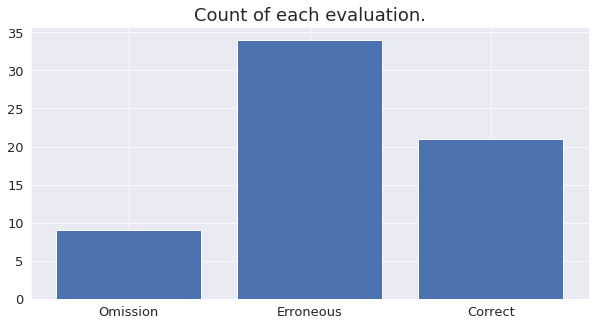

In [5]:
plt.figure(figsize=(10,5))

plt.bar(summed_choices.keys(), summed_choices.values())
plt.title("Count of each evaluation.")
plt.show()

## Inference examples

In [ ]:
category = "Erroneous"

for evaluation in evaluations:
    if category in evaluation['evaluation']:
        print("-"*100)
        print(f"Target: {evaluation['target']}\n")
        print(f"Predicted: {evaluation['predicted']}\n")
        print(f"Source: {evaluation['source']}\n")
        print("-"*100)

## Detailed Human Evaluation

### Reading the files

In [30]:
evaluations_dir = 'storage/results/human_evaluation/qr2t/evaluated/08_16_2022__12_56_13'

all_annotations = []
for file in glob.glob(f"../{evaluations_dir}/*.json"):
    with open(file) as f:
        evaluations = json.load(f)
    annotator = file.split('/')[-1][:-5]

    for evaluation in evaluations:
        eval_choices = evaluation['annotations'][0]['result']
        
        def find_ind_of_attribute(attribute):
            for ind, val in enumerate(eval_choices):
                if val['from_name'] == attribute:
                    return ind
            return -1
        
        try:
            eval_info = [
                evaluation['data']['id'],
                evaluation['data']['model'],
                evaluation['data']['nl_query'],
                evaluation['data']['results_table'],
                evaluation['data']['inference'],
                annotator,
                eval_choices[find_ind_of_attribute('correctness')]['value']['choices'][0],
                eval_choices[find_ind_of_attribute('fluency')]['value']['choices'][0],
                eval_choices[find_ind_of_attribute('syntax_errors')]['value']['number'],
                eval_choices[find_ind_of_attribute('value_usage_error')]['value']['number'],
                eval_choices[find_ind_of_attribute('omisions')]['value']['number'],
                eval_choices[find_ind_of_attribute('altered_values')]['value']['number'],
                eval_choices[find_ind_of_attribute('added_attributes')]['value']['number'],
                eval_choices[find_ind_of_attribute('other')]['value']['number'],
                eval_choices[find_ind_of_attribute('comment')]['value']['text'][0] if find_ind_of_attribute('comment') != -1 else ""            
            ]
        except KeyError:
            print(annotator)
            print(evaluation['data'])
            print("#" * 120)
        all_annotations.append(eval_info)

In [31]:
eval_df = pd.DataFrame(all_annotations, columns=['id', 'model', 'nl_query', 'results_table', 'inference', 'annotator', 'correctness', 
                                                 'fluency', 'syntax_errors', 'value_usage_error', 
                                                 'omisions', 'altered_values', 'added_attributes',
                                                 'other', 'comment'])

display(eval_df)

,id,model,nl_query,results_table,inference,annotator,correctness,fluency,syntax_errors,value_usage_error,omisions,altered_values,added_attributes,other,comment
0,245,totto_qr2t,Return the dates of ceremony corresponding to ...,"{'Result': 'Awarded', 'Category': 'Best Song',...","The music festival that had the category ""Best...",Stavroula,Incorrect,Adequate,0,1,0,0,0,0,
1,31,aux_totto_qr2t,"Show the name, open date, and organizer for al...","{'Name': 'Pure Church of Christ', 'Open_Date':...",The Church Pure Church of Christ was organized...,Stavroula,Incorrect,Perfect,0,0,1,0,0,0,
2,31,pre_totto_qr2t,"Show the name, open date, and organizer for al...","{'Name': 'Pure Church of Christ', 'Open_Date':...","In 1831, the Pure Church of Christ was organiz...",Stavroula,Correct,Perfect,0,0,0,0,0,0,
3,31,qr2t,"Show the name, open date, and organizer for al...","{'Name': 'Pure Church of Christ', 'Open_Date':...",The Pure Church of Christ was organized in 183...,Stavroula,Correct,Perfect,0,0,0,0,0,0,
4,31,totto_qr2t,"Show the name, open date, and organizer for al...","{'Name': 'Pure Church of Christ', 'Open_Date':...",The Church named Pure Church of Christ was org...,Stavroula,Correct,Perfect,0,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,105,totto_qr2t,Give me the average and minimum price (in Euro...,{'average price_in_euros': '492.8633333333334'...,The average price of the products is 492.86333...,Antonis,Correct,Perfect,0,0,0,0,0,0,
1240,113,pre_totto_qr2t,How many entrepreneurs correspond to each inve...,"{'Investor': 'Doug Richard', 'count of entrepr...",Doug Richard is one of the entrepreneurs.,Antonis,Incorrect,Perfect,0,1,2,0,0,0,
1241,5,totto_qr2t,What are the login names of the students with ...,"{'login_name': 'annamae.hoppe', 'family_name':...",The login name of the student with family name...,Antonis,Correct,Adequate,0,0,0,0,0,0,
1242,109,pre_totto_qr2t,What is the average price for flights from Los...,"{'origin': 'Los Angeles', 'destination': 'Hono...",Flight 400.605 was from Los Angeles to Honolulu.,Antonis,Incorrect,Not fluent,0,1,0,0,0,0,


### Correctness of each model

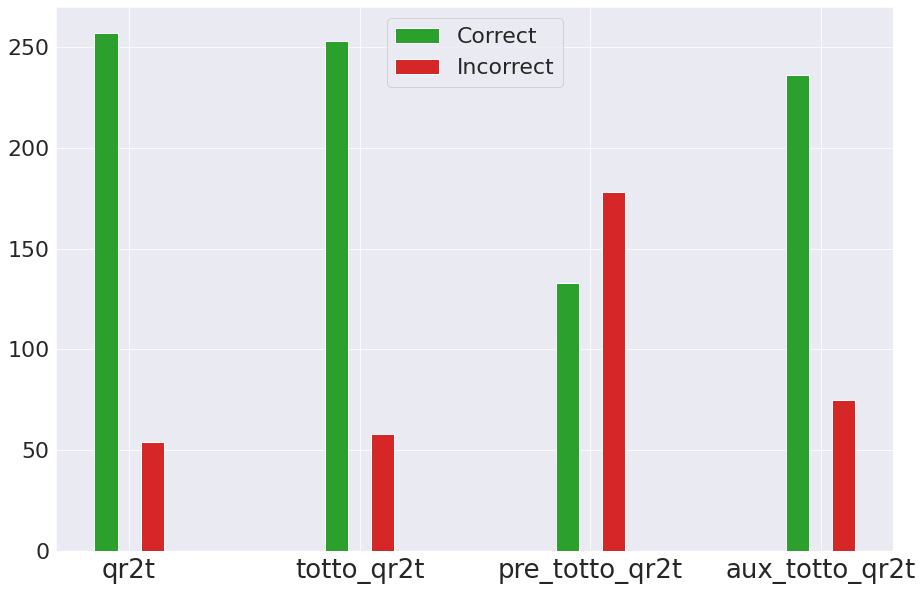

In [ ]:
def get_number_of_correct_wrong(model_name, eval_df):
    df_model = eval_df.loc[eval_df['model'] == model_name]
    
    return len(df_model.loc[df_model['correctness'] == 'Correct']), len(df_model.loc[df_model['correctness'] == 'Incorrect'])


fig, ax = plt.subplots(figsize=(15,10))

models = ['qr2t', 'totto_qr2t', 'pre_totto_qr2t', 'aux_totto_qr2t']
current_step = 1

for model_name in models:
    correct, wrong = get_number_of_correct_wrong(model_name, eval_df)


    plt.bar([current_step], [correct], width=0.1, color='tab:green', label="Correct" if model_name == 'qr2t' else None)
    plt.bar([current_step + 0.2], [wrong], width=0.1, color='tab:red', label="Incorrect" if model_name == 'qr2t' else None)
    
    current_step += 1

plt.xticks(np.arange(1.1, 5.1), fontsize=26)
plt.yticks(fontsize=22)
ax.set_xticklabels(models)

plt.legend(fontsize=22)
# plt.title('Correctness', fontsize=23)

fig.savefig('../storage/results/plots/correctness.svg', format='svg', dpi=1200)
plt.show()

### Flunecy of each model

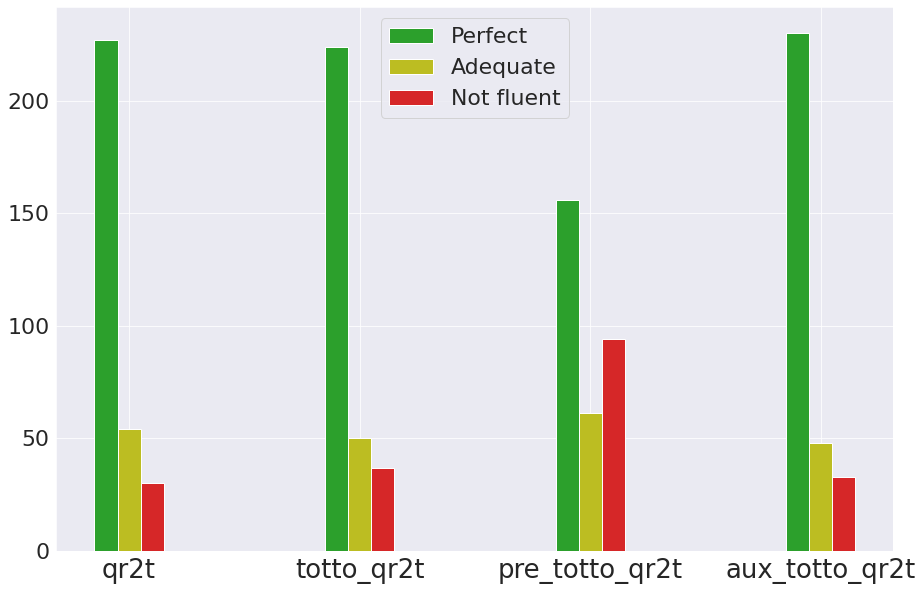

In [8]:
def get_number_of_perfect_adequate_bad(model_name, eval_df):
    df_model = eval_df.loc[eval_df['model'] == model_name]
    
    return len(df_model.loc[df_model['fluency'] == 'Perfect']), len(df_model.loc[df_model['fluency'] == 'Adequate']), len(df_model.loc[df_model['fluency'] == 'Not fluent'])


fig, ax = plt.subplots(figsize=(15,10))

models = ['qr2t', 'totto_qr2t', 'pre_totto_qr2t', 'aux_totto_qr2t']
current_step = 1

for model_name in models:
    perfect, adequate, not_fluent = get_number_of_perfect_adequate_bad(model_name, eval_df)

    plt.bar([current_step], [perfect], width=0.1, color='tab:green', label="Perfect" if model_name == 'qr2t' else None)
    plt.bar([current_step + 0.1], [adequate], width=0.1, color='tab:olive', label="Adequate" if model_name == 'qr2t' else None)
    plt.bar([current_step + 0.2], [not_fluent], width=0.1, color='tab:red', label="Not fluent" if model_name == 'qr2t' else None)

    current_step += 1

plt.xticks(np.arange(1.1, 5.1), fontsize=26)
plt.yticks(fontsize=22)
ax.set_xticklabels(models)

plt.legend(fontsize=22)
# plt.title('Fluency', fontsize=23)

fig.savefig('../storage/results/plots/fluency.svg', format='svg', dpi=1200)
plt.show()

### Winnning Model

In [60]:
qual_eval_df = eval_df.copy()


dfs_per_model = {
    'qr2t': qual_eval_df.loc[qual_eval_df['model'] == 'qr2t'],
    'totto_qr2t': qual_eval_df.loc[qual_eval_df['model'] == 'totto_qr2t'],
    # 'pre_totto_qr2t': qual_eval_df.loc[qual_eval_df['model'] == 'pre_totto_qr2t'],
    'aux_totto_qr2t': qual_eval_df.loc[qual_eval_df['model'] == 'aux_totto_qr2t'],
}

dfs_correctness_per_model = {key: df.filter(['id', 'correctness', 'nl_query', 'results_table', 'inference'] if key == 'qr2t' else ['id', 'correctness', 'inference'])
                             .rename(columns={column: f'{key}_{column}' 
                                              for column in dfs_per_model[key].columns if column != 'id'}) 
                             for key, df in dfs_per_model.items()}



df_outer = pd.merge(dfs_correctness_per_model['qr2t'], dfs_correctness_per_model['totto_qr2t'], on='id', how='inner')
# df_outer = pd.merge(df_outer, dfs_correctness_per_model['pre_totto_qr2t'], on='id', how='inner')
df_outer = pd.merge(df_outer, dfs_correctness_per_model['aux_totto_qr2t'], on='id', how='inner').drop(['id'], axis=1)

df_outer = df_outer.replace(['Correct', 'Incorrect'], [1, 0])


display(df_outer)

,qr2t_correctness,qr2t_nl_query,qr2t_results_table,qr2t_inference,totto_qr2t_correctness,totto_qr2t_inference,aux_totto_qr2t_correctness,aux_totto_qr2t_inference
0,1,"Show the name, open date, and organizer for al...","{'Name': 'Pure Church of Christ', 'Open_Date':...",The Pure Church of Christ was organized in 183...,1,The Church named Pure Church of Christ was org...,0,The Church Pure Church of Christ was organized...
1,1,Find the name and gender type of the dorms who...,"{'gender': 'X', 'dorm_name': 'Smith Hall', 'st...",Smith Hall has a gender of X and its student c...,1,The gender of the dorm Smith Hall is X and the...,0,Smith Hall dorms have capacity greater than 30...
2,1,"Show the zip code of the county with name ""How...","{'Zip_code': 'D21', 'County_name': 'Howard'}",The county with zip code D21 has name Howard.,1,The zip code is D21 and the county name is How...,1,The zip code D21 is Howard.
3,1,List the names of patients who have made appoi...,{'Name': 'John Smith'},John Smith has made appointments.,1,John Smith has made appointments,1,John Smith has made appointments.
4,1,What is the average age for a male in each job?,"{'job': 'doctor', 'gender': 'male', 'average a...",The average age of a male in the doctor job is...,1,The average age of the doctor is 45 and the ge...,0,The average age for a male is 45.
...,...,...,...,...,...,...,...,...
306,1,Count the number of video games with Massively...,"{'GType': 'Massively multiplayer online game',...",There is 1 video game with type Massively mult...,1,The number of video games with type Massively ...,0,There is 1 video game with a Massively multipl...
307,0,Show the countries that have managers of age a...,"{'Age': '45', 'Country': 'United States'}",The age of 45 is in the United States.,1,The United States has managers of age above 45.,1,The United States has managers of age above 50...
308,1,How many employees have a first name of Ludie?,"{'first_name': 'Ludie', 'count of Staff': '1'}",There is 1 staff named Ludie.,0,Ludie has 1 staff.,0,Ludie has 1 staff.
309,1,Return the phone and email of the customer wit...,"{'customer_email': 'fahey.dorian@example.com',...",The customer Aniyah Feest has the email fahey....,1,The customer Aniyah Feest has the phone (673)8...,1,The customer Aniyah Feest has the email fahey....


In [61]:
all_models = {'qr2t', 'totto_qr2t', 'aux_totto_qr2t'}


def specific_model_mistakes(df, model_name):
    other_models = all_models.difference({model_name})
    
    mask = df[f'{model_name}_correctness'] == 0
    conds = [df[f'{model}_correctness'] == 1 for model in other_models]
    
    for cond in conds:
        mask = mask & cond
        
    return df[mask]


def pretty_display(df, model_name):
    df = df.filter([col for col in df.columns if 'correctness' not in col])
    df = df.rename({'qr2t_nl_query': 'nl_query', 'qr2t_results_table': 'results_table'})
    
    def highlight_cols(s):
        color = '#f7e4e4'
        return 'background-color: %s' % color
    
    df = df.style.applymap(highlight_cols, subset=pd.IndexSlice[:, [f'{model_name}_inference']])
    
    return df
    
def add_sheet_to_excel(writer, model_name):
    mistakes = specific_model_mistakes(df_outer, model_name)
    mistakes = pretty_display(mistakes, model_name)
    mistakes.to_excel(writer, sheet_name=model_name)

    
writer = pd.ExcelWriter('../storage/results/human_evaluation/mistakes_no_pre.xlsx', engine='xlsxwriter')
for model in all_models:
    add_sheet_to_excel(writer, model)
    
writer.save()

### Mistakes analysis

In [25]:
models = ['qr2t', 'totto_qr2t', 'pre_totto_qr2t', 'aux_totto_qr2t']

def ret_mistakes_per_category(model_name, df):
    df_model = df.loc[df['model'] == model_name]
    df_model = df_model.loc[df_model['correctness']=='Incorrect']

    df_error_sums = df_model[['syntax_errors', 'value_usage_error', 'omisions', 'altered_values', 'added_attributes', 'other']].sum(axis=0)
    
    return pd.DataFrame(df_error_sums, columns=[model_name])
    

df_all_models = ret_mistakes_per_category(models[0], eval_df)
for model in models[1:]:
    df_all_models = df_all_models.join(ret_mistakes_per_category(model, eval_df), how='inner')
    
df_all_models

,qr2t,totto_qr2t,pre_totto_qr2t,aux_totto_qr2t
syntax_errors,10,15,26,10
value_usage_error,28,37,183,42
omisions,19,16,48,46
altered_values,2,1,17,4
added_attributes,2,2,14,5
other,8,5,5,2
